# Customer churn

Customer churn is an important metric to track because lost customers equal lost revenue. If a company loses enough customers, it can have a high impact on business profits. So reducing customer churn is critical for every company.

In [ ]:
# import necessary librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn

import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Data preprocessing

The Data used here is a data downloaded from www.kaggle.com: <a href=https://www.kaggle.com/datasets/blastchar/telco-customer-churn > telecom customer churn </a>

In [ ]:
# Read the data
customerChurnData = pd.read_csv('/content/drive/MyDrive/Telecom-Customer-Churn.csv')

customerChurnData.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# The target feature
customerChurnData.Churn.head ()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [ ]:
# Changing data to numerical variables
binary_variable_column = {'Yes': 1, 'No': 0, 'No phone service': 0, 'Male': 1 , 'Female': 0,}
data_with_binary = customerChurnData.replace(binary_variable_column).drop('customerID', axis = 1)

data_with_binary = data_with_binary[(data_with_binary.TotalCharges != ' ')]

data_with_binary.TotalCharges = np.array(data_with_binary.TotalCharges, np.float64)

data = pd.get_dummies(data_with_binary)

del data_with_binary

In [ ]:
#normalize the data
def normalize(data):
    for column in data.columns:
        data[column] = data[column]/data[column].max()
normalize(data)

When dealing with machibe learning data, the fist thing to do is checking data correlation
Maybe some features are highly correlated(or sometimes they are the same), we need to reduce redundance.

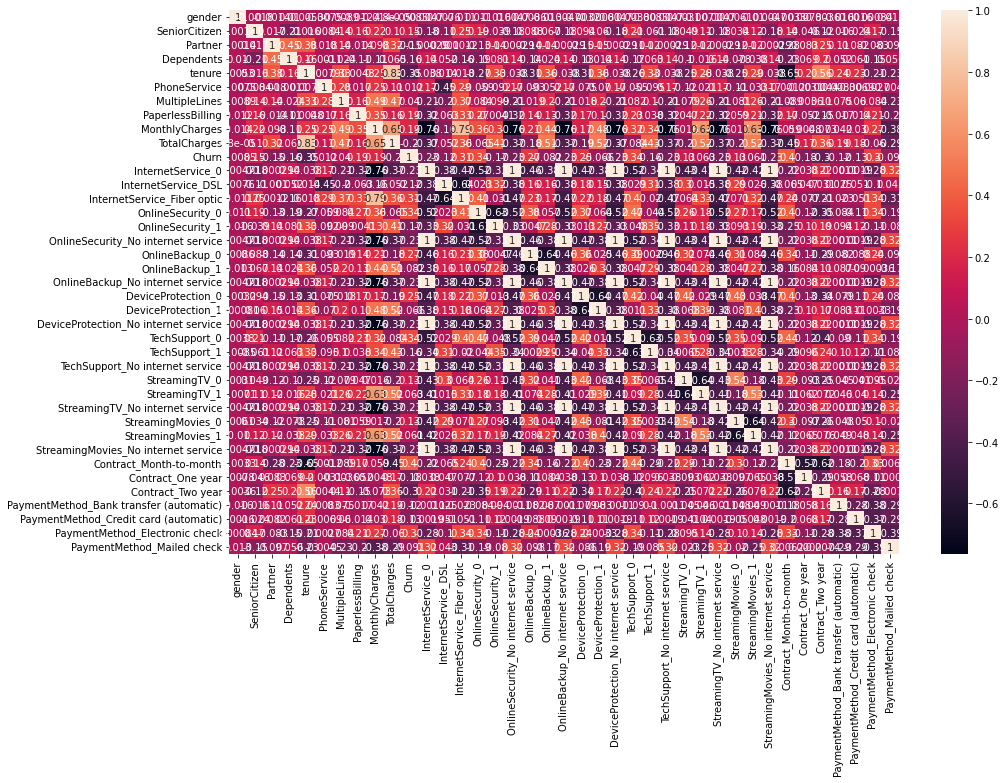

In [ ]:
final_data = data.sample(len(data), random_state = 26)

fig, axes = plt.subplots(figsize = (15,10))
cor = final_data.corr()
sns.heatmap(cor, annot =  True)
plt.show()

We need to drop these duplicates features.

In [ ]:
to_drop = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service',
          'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']

final_data= final_data.drop(to_drop, axis = 1)


# Model trainnig

In [ ]:
#Split the data into train - test data
X_train, X_test, y_train, y_test = train_test_split(final_data.drop('Churn', axis = 1) , final_data.Churn , test_size=0.1, random_state=42)

In [ ]:
metrics_train = pd.DataFrame([], columns = ['auc_score','precision','recall','f1_score','accuracy','Columns_number'])
metrics_test = pd.DataFrame([], columns = ['auc_score','precision','recall','f1_score','accuracy','Columns_number'])

#Create necessary functions

def compute_metrics(model, X, y, name):
    metrics = {}
    prediction_probability = model.predict_proba(X)
    prediction_class = model.predict(X)
    metrics['auc_score'] = roc_auc_score( y, prediction_probability[:,1])
    metrics['precision'],  metrics['recall'], metrics['f1_score'], _= sklearn.metrics.precision_recall_fscore_support(y, prediction_class, average ='binary')
    metrics['accuracy'] = accuracy_score(y, prediction_class)
    metrics['Columns_number'] = len(X.columns)
    df_metrics = pd.DataFrame(metrics, index = [name])
    return df_metrics


def plot_correlation(model, X_train, y_train, X_test, y_test, axe = None, step = 1):
    cor = pd.concat([X_train, y_train], axis = 1).corr()
    most_correlated = abs(cor.Churn[cor.Churn.index != 'Churn']).sort_values(ascending = False)
    score_train , score_test = [], []
    for i in range(1, len(X_train.columns) +1, step):
        most_correlated_columns = most_correlated[:i].index
        X_train_cor = X_train[most_correlated_columns]
        X_test_cor = X_test[most_correlated_columns]
        model.fit(X_train_cor, y_train, eval_metric = 'auc', verbose = 10, )
        prediction_probability_train = model.predict_proba(X_train_cor)
        prediction_probability_test = model.predict_proba(X_test_cor)
        score_train.append(roc_auc_score( y_train, prediction_probability_train[:,1]))
        score_test.append(roc_auc_score( y_test, prediction_probability_test[:,1]))
    plt.plot(range(len(score_train)), score_train)
    plt.plot(range(len(score_train)), score_test)

def plot_RFE(model, X_train, y_train, X_test, y_test, axe = None, step = 1):
    score_train , score_test = [], []
    for i in range(1, len(X_train.columns) + 1, step):
        rfe_selector = feature_selection.RFE(model,  n_features_to_select= i, step = step)
        feature_selected = X_train.columns[rfe_selector.fit(X_train, y_train).support_]

        X_train_RFE = X_train[feature_selected]
        X_test_RFE = X_test[feature_selected]
        model.fit(X_train_RFE, y_train, eval_metric = 'auc', verbose = 10, )
        prediction_probability_train = model.predict_proba(X_train_RFE)
        prediction_probability_test = model.predict_proba(X_test_RFE)
        score_train.append(roc_auc_score( y_train, prediction_probability_train[:,1]))
        score_test.append(roc_auc_score( y_test, prediction_probability_test[:,1]))
    plt.plot(range(len(score_train)), score_train)
    plt.plot(range(len(score_train)), score_test)

def plot_fi(model, X_train, y_train, X_test, y_test, axe = None, step = 1):
    score_train , score_test = [], []
    model.fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_, index = X_train.columns)
    feature_importance = feature_importance / feature_importance.sum()
    for i in range(1, len(X_train.columns) + 1, step):
        column_feature_importance = feature_importance.sort_values(ascending = False)[:i].index

        X_train_fi = X_train[column_feature_importance]
        X_test_fi = X_test[column_feature_importance]
        model.fit(X_train_fi, y_train, eval_metric = 'auc', verbose = 10, )
        prediction_probability_train = model.predict_proba(X_train_fi)
        prediction_probability_test = model.predict_proba(X_test_fi)
        score_train.append(roc_auc_score( y_train, prediction_probability_train[:,1]))
        score_test.append(roc_auc_score( y_test, prediction_probability_test[:,1]))
    plt.plot(range(len(score_train)), score_train)
    plt.plot(range(len(score_train)), score_test)

When doing business analysis, we need to optimize the number of features we use, because we need simpler model for interpreatbility,
also with small features we can reduce cost of gathering data, and reducing error when collecting data. So our first goal is to produce a good model
whith minimum number of features.

In [ ]:
print(f"percentage of customers who churn: {final_data.Churn.sum()/len(final_data)}")

percentage of customers who churn: 0.26578498293515357


We have a binary classifiaction with imbalanced data, so we will use **AUC** to measure the quality of our model. With imbalanced data, it can be more flexible to predict probabilities of an observation belonging to each class in a classification problem rather than predicting classes directly. A score between 0.7 and 0.80 is considered as acceptable, a score between 0.80 and 0.9 is good, and a score >0.9 is excellent.

Feature selection increases the predictive power of machine learning algorithms by selecting the most important variables and eliminating irrelevant featurant.
We will use:
<br>**Filter Method**, using correlation</br>
<br>**Wrapper method**, using Recursive Feature Elimination</br>
<br>**Embeded Method**, using feature importance</br>

# Filter Methods (using correlation)

In [ ]:
#Compute correlation and the n features most correlated with Churn
cor = final_data.corr()
most_correlated = abs(cor.Churn[cor.Churn.index != 'Churn']).sort_values(ascending = False)
most_correlated = most_correlated[:12].index

In [ ]:
#Changing x_train
X_train_cor = X_train[most_correlated]

In [ ]:
model_cor = lgb.LGBMClassifier(num_leaves = 20, objective = 'binary', learning_rate = 0.01)

model_cor.fit(X_train_cor, y_train, eval_metric = 'auc', verbose = 10, )

LGBMClassifier(learning_rate=0.01, num_leaves=20, objective='binary')

In [ ]:
#Estimate the test set score with cross-validation
cross_val_score(model_cor, X_train_cor, y_train, cv = 4, scoring ='roc_auc')

array([0.84385952, 0.84051753, 0.83431435, 0.83698425])

In [ ]:
#Compute metrics
X_test_cor = X_test[most_correlated]

metrics_test_cor = compute_metrics(model_cor, X_test_cor, y_test,'correlation')
metrics_train_cor = compute_metrics(model_cor, X_train_cor, y_train, 'correlation')

metrics_train = pd.concat([metrics_train, metrics_train_cor])
metrics_test = pd.concat([metrics_test, metrics_test_cor])

display(metrics_train_cor)
display(metrics_test_cor)

,auc_score,precision,recall,f1_score,accuracy,Columns_number
correlation,0.860618,0.78673,0.295724,0.429866,0.791245,12


,auc_score,precision,recall,f1_score,accuracy,Columns_number
correlation,0.85495,0.746667,0.302703,0.430769,0.789773,12


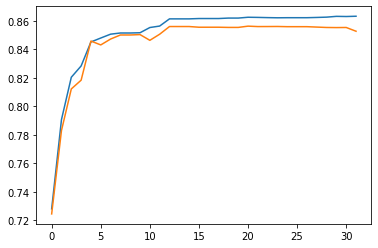

In [ ]:
plot_correlation(model_cor, X_train, y_train, X_test, y_test)

#  Wrapper methods (using Recursive Feature Elimination)

In [ ]:
model_RFE = lgb.LGBMClassifier(num_leaves = 35, objective = 'binary', learning_rate = 0.01)

In [ ]:
#Feature selection with RFE model
rfe_selector = feature_selection.RFE(model_RFE,  n_features_to_select= 9, step = 1)

feature_selected = rfe_selector.fit(X_train, y_train)

#Create the new x_train
X_train_RFE = X_train[X_train.columns[feature_selected.support_]]

In [ ]:
#Fit the model to the new data
model_RFE.fit(X_train_RFE, y_train, eval_metric = 'auc', verbose = 10,)

LGBMClassifier(learning_rate=0.01, num_leaves=35, objective='binary')

In [ ]:
#Estimate the test score with cross-validation
cross_val_score(model_RFE, X_train_RFE, y_train, cv = 4, scoring ='roc_auc')

array([0.83481559, 0.82368996, 0.83264079, 0.82494819])

In [ ]:
#Compute_metrics
X_test_RFE= X_test[X_test.columns[feature_selected.support_]]

metrics_test_RFE = compute_metrics(model_RFE, X_test_RFE, y_test,'RFE')
metrics_train_RFE = compute_metrics(model_RFE, X_train_RFE, y_train, 'RFE')

metrics_train = pd.concat([metrics_train, metrics_train_RFE])
metrics_test = pd.concat([metrics_test, metrics_test_RFE])

display(metrics_train_RFE)
display(metrics_test_RFE)

,auc_score,precision,recall,f1_score,accuracy,Columns_number
RFE,0.863115,0.810264,0.309382,0.447787,0.796934,9


,auc_score,precision,recall,f1_score,accuracy,Columns_number
RFE,0.859824,0.777778,0.340541,0.473684,0.801136,9


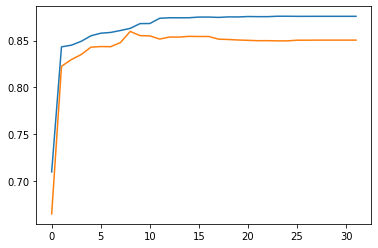

In [ ]:
#Plot AUC score for n number of features
plot_RFE(model_RFE, X_train, y_train, X_test, y_test, axe = None, step = 1)

# Embedded Methods (using model features importances)

In [ ]:
#Create model and fit it to the orginal x_train
model_embed = lgb.LGBMClassifier(num_leaves = 35, objective = 'binary', learning_rate = 0.01)
model_embed.fit(X_train, y_train, eval_metric = 'auc', verbose = 10,)

LGBMClassifier(learning_rate=0.01, num_leaves=35, objective='binary')

In [ ]:
#Gather feature importances from model
feature_importance = pd.Series(model_embed.feature_importances_, index = X_train.columns)

feature_importance = feature_importance / feature_importance.sum()

In [ ]:
feature_importance.sort_values(ascending = False)[:9]

MonthlyCharges                    0.189118
tenure                            0.174118
TotalCharges                      0.131176
PaymentMethod_Electronic check    0.047059
Contract_One year                 0.043235
MultipleLines                     0.038529
PaperlessBilling                  0.038235
OnlineSecurity_0                  0.032059
Contract_Month-to-month           0.029412
dtype: float64

In [ ]:
#Select only the n most important features
column_feature_importance = feature_importance.sort_values(ascending = False)[:9].index
X_train_fi = X_train[column_feature_importance]

In [ ]:
#fit the model to the new x_train
model_embed = lgb.LGBMClassifier(num_leaves = 35, objective = 'binary', learning_rate = 0.01)
model_embed.fit(X_train_fi, y_train, eval_metric = 'auc', verbose = 10,)

LGBMClassifier(learning_rate=0.01, num_leaves=35, objective='binary')

In [ ]:
#Estimate the test set ecore with cross_validation
cross_val_score(model_embed, X_train_fi, y_train, cv = 4, scoring ='roc_auc')

array([0.8416704 , 0.83828647, 0.8331983 , 0.83539151])

In [ ]:
#Compute_metrics
X_test_fi = X_test[column_feature_importance]

metrics_test_fi = compute_metrics(model_embed, X_test_fi, y_test,'feature importance')
metrics_train_fi = compute_metrics(model_embed, X_train_fi, y_train,'feature importance')

metrics_train = pd.concat([metrics_train, metrics_train_fi])
metrics_test = pd.concat([metrics_test, metrics_test_fi])

display(metrics_train_fi)
display(metrics_test_fi)

,auc_score,precision,recall,f1_score,accuracy,Columns_number
feature importance,0.870769,0.798592,0.336698,0.473684,0.800885,9


,auc_score,precision,recall,f1_score,accuracy,Columns_number
feature importance,0.847961,0.777778,0.340541,0.473684,0.801136,9


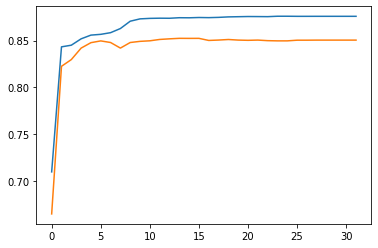

In [ ]:
#Plot AUC score for n number of features
plot_fi (model_embed, X_train, y_train, X_test, y_test)

In [ ]:
metrics_train.drop_duplicates()

,auc_score,precision,recall,f1_score,accuracy,Columns_number
correlation,0.860618,0.786730,0.295724,0.429866,0.791245,12
RFE,0.863115,0.810264,0.309382,0.447787,0.796934,9
feature importance,0.870769,0.798592,0.336698,0.473684,0.800885,9


In [ ]:
metrics_test.drop_duplicates()

,auc_score,precision,recall,f1_score,accuracy,Columns_number
correlation,0.854950,0.746667,0.302703,0.430769,0.789773,12
RFE,0.859824,0.777778,0.340541,0.473684,0.801136,9
feature importance,0.847961,0.777778,0.340541,0.473684,0.801136,9


As conclusion we can use the model with Recursive Feature Elimination, with nine numbers of features used

In [ ]:
X_train_RFE.columns

Index(['tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'TechSupport_0', 'StreamingMovies_0',
       'Contract_One year', 'PaymentMethod_Electronic check'],
      dtype='object')